In [1]:
import json
import csv
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import itertools
import string
from nltk.corpus import stopwords
from sklearn.utils import resample
import gensim
from sklearn import preprocessing
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import KeyedVectors
import copy

from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from trtokenizer.tr_tokenizer import SentenceTokenizer, WordTokenizer
word_tokenizer_object = WordTokenizer()

import warnings
warnings.filterwarnings('ignore')

In [2]:
test = pd.read_csv('test_10_topic.csv', sep='\t')
df_1000 = pd.read_csv('df_1000.csv', sep='\t')
df_hel = pd.read_csv('df_1000_helsinki.csv', sep='\t')
df_det = pd.read_csv('df_1000_detailed.csv', sep='\t')
df_2000 = pd.concat([df_1000, df_1000])

In [3]:
df_1000['title'][509]

'Elektronik sigara kanser ve kalp hastalığı nedeni'

In [4]:
df_hel['title'][1509]

'Elektronik sigaralar kansere ve kalp hastalığına neden olur'

In [5]:
df_det['title'][1509]

"['İstanbul’da yapılan bir araştırma, elektronik sigara gibi kanserlerin kalp hastalıklarından daha önemli bir sebep olduğunu ortaya koydu.']"

In [6]:
class_names = np.unique(df_1000['topic'])
class_names

array(['Dünya', 'Ekonomi', 'Eğitim', 'Kültür_Sanat', 'Magazin',
       'Otomobil', 'Sağlık', 'Siyaset', 'Spor', 'Teknoloji'], dtype=object)

In [7]:
df_hel = df_hel.drop(index=[264, 314, 341, 359, 1264, 1314, 1341, 1359])
df_det = df_det.drop(index=[264, 314, 341, 359, 1264, 1314, 1341, 1359])
df_2000 = df_2000.drop(index=[264, 314, 341, 359])
df_1000 = df_1000.drop(index=[264, 314, 341, 359])

<AxesSubplot:xlabel='topic', ylabel='count'>

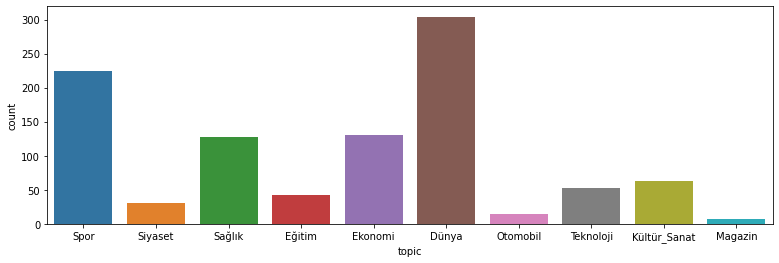

In [8]:
plt.figure(figsize=(13, 4))
sns.countplot(df_1000['topic'])

### Word2Vec

In [9]:
word_vectors = KeyedVectors.load_word2vec_format("C:/Users/asus/NLP/STAR/NEW_DATASET/DATA-AUG/trmodel", binary=True)

In [10]:
def clean_text(text):
    
    text = text.lower()   
    text = text.translate(str.maketrans('', '', string.punctuation)) # !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
    words = word_tokenizer_object.tokenize(text)
    stopWords = set(stopwords.words('turkish'))
    new_text = [word for word in words if word not in stopWords]

    return new_text

In [11]:
word_vectors['kelime'].shape

(400,)

In [13]:
test.title = [clean_text(text) for text in test.title]

In [14]:
t = test['title'][0]
t

['sahada', 'başlayan', 'kavga', 'tribüne', 'sıçradı', '8', 'kırmızı', 'kart']

In [15]:
label_encoder = preprocessing.LabelEncoder()
test['topic']= label_encoder.fit_transform(test['topic'])

In [16]:
X_test_vect = np.array([np.array([word_vectors[i] for i in ls if i in word_vectors]) for ls in test['title']])

In [17]:
X_test_vect[0].shape

(7, 400)

In [18]:
def vect_avg(vect):
    vect_avg = []
    for v in vect:
        if v.size:
            vect_avg.append(v.mean(axis=0))
        else:
            vect_avg.append(np.zeros(400, dtype=float))
    return vect_avg

In [19]:
X_test_vect_avg = vect_avg(X_test_vect)

In [21]:
def execute_model(model):
    
    scores_f1 = []
    
    pipe = make_pipeline(model)
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    length = len(df)//2

    for n_fold, (_, val_i) in enumerate(kf.split(range(length))):
        
        after_half = np.asarray([(i + length) for i in val_i])
        val_index = np.concatenate((val_i, after_half))
        train_index = list(set(list(range(0, len(df)))) - set(val_index))
        

        X_train = df.iloc[train_index]['title']
        y_train = df.iloc[train_index]['topic']
        
        X_valid = test['title']
        y_valid = test['topic']
        
        
        X_train_vect = np.array([np.array([word_vectors[i] for i in ls if i in word_vectors]) for ls in X_train])    
        X_train_vect_avg = vect_avg(X_train_vect)
        
        X_test_vect = np.array([np.array([word_vectors[i] for i in ls if i in word_vectors]) for ls in X_valid])
        X_test_vect_avg = vect_avg(X_test_vect)
        
        pipe.fit(X_train_vect_avg, y_train.values.ravel())
        y_pred = pipe.predict(X_test_vect_avg)

        f1 = f1_score(y_valid, y_pred, average='macro')        
        scores_f1.append(f1)
        
    print(np.mean(scores_f1), '\t', np.std(scores_f1))
    
    return pipe, np.mean(scores_f1), np.std(scores_f1)

In [22]:
datasets = [df_1000, df_2000, df_hel, df_det]

In [23]:
lsvc_f1s = []
lsvc_stds = []

for dataset in datasets:
    
    df = copy.deepcopy(dataset)
    
    df.title = [clean_text(text) for text in df.title]
    df['topic']= label_encoder.transform(df['topic'])
    """X_train_vect = np.array([np.array([word_vectors[i] for i in ls if i in word_vectors]) for ls in df['title']])
    
    X_train_vect_avg = vect_avg(X_train_vect)"""
    
    lsvc_pipe, lsvc_f1_mean, lsvc_std = execute_model(LinearSVC())
    lsvc_f1s.append(lsvc_f1_mean)
    lsvc_stds.append(lsvc_std)
    
lsvc_f1s =  [f"{num:.3f}" for num in lsvc_f1s]
lsvc_stds =  [f"{num:.3f}" for num in lsvc_stds]

0.4001795540518641 	 0.007733147382139614
0.38986103230159225 	 0.00965217727003647
0.378051162828796 	 0.004462477431637024
0.40405196021022355 	 0.012050007818368265


In [24]:
rf_f1s = []
rf_stds = []

for dataset in datasets:
    
    df = copy.deepcopy(dataset)
    
    df.title = [clean_text(text) for text in df.title]
    df['topic']= label_encoder.transform(df['topic'])
    
    rf_pipe, rf_f1_mean, rf_std = execute_model(RandomForestClassifier())
    rf_f1s.append(rf_f1_mean)
    rf_stds.append(rf_std)
    
rf_f1s =  [f"{num:.3f}" for num in rf_f1s]
rf_stds =  [f"{num:.3f}" for num in rf_stds]

0.2809917854702825 	 0.003541716087776515
0.2930321264653204 	 0.00401169638731537
0.29469834365790054 	 0.005224330179216284
0.3344618365978951 	 0.014584632304054783


In [25]:
lr_f1s = []
lr_stds = []

for dataset in datasets:
    
    df = copy.deepcopy(dataset)
    
    df.title = [clean_text(text) for text in df.title]
    df['topic']= label_encoder.transform(df['topic'])
    
    lr_pipe, lr_f1_mean, lr_std = execute_model(LogisticRegression())
    lr_f1s.append(lr_f1_mean)
    lr_stds.append(lr_std)
    
lr_f1s =  [f"{num:.3f}" for num in lr_f1s]
lr_stds =  [f"{num:.3f}" for num in lr_stds]

0.4515155701801781 	 0.0062415834546784175
0.4475496773028652 	 0.007890797886175974
0.4411620321768529 	 0.007273399930098413
0.46668630827009006 	 0.008925429762563497


In [26]:
print("\nF1-Score Table:")
f1_df = {'Dataset': ['ds_1000', 'ds_1000_copy', 'ds_1000_back', 'ds_1000_det'], 
             'Linear_SVC': lsvc_f1s, 
             'Random_forest': rf_f1s, 
             'Logistic_regression': lr_f1s}

f1_df = pd.DataFrame.from_dict(f1_df).set_index('Dataset')
f1_df


F1-Score Tablosu:


,Linear_SVC,Random_forest,Logistic_regression
Dataset,,,
ds_1000,0.400,0.281,0.452
ds_1000_copy,0.390,0.293,0.448
ds_1000_back,0.378,0.295,0.441
ds_1000_det,0.404,0.334,0.467


In [27]:
print("\nStandard Deviation Table:")
std_df = {'Dataset': ['ds_1000', 'ds_1000_copy', 'ds_1000_back', 'ds_1000_det'], 
             'Linear_SVC': lsvc_stds, 
             'Random_forest': rf_stds, 
             'Logistic_regression': lr_stds}

std_df = pd.DataFrame.from_dict(std_df).set_index('Dataset')
std_df


Standart Sapma Tablosu:


,Linear_SVC,Random_forest,Logistic_regression
Dataset,,,
ds_1000,0.008,0.004,0.006
ds_1000_copy,0.010,0.004,0.008
ds_1000_back,0.004,0.005,0.007
ds_1000_det,0.012,0.015,0.009
